In [15]:
import numpy as np
from skimage import color
import matplotlib.pyplot as plt
from keras.layers import Dense, Input, Conv2D, Conv2DTranspose, Flatten, Reshape, MaxPool2D
from keras.models import Model
from keras.layers import BatchNormalization, Dropout, Activation, concatenate
from tensorflow.keras.callbacks import ModelCheckpoint

In [2]:
pfcn_small = np.load(r'/Users/sunhyeoklee/Desktop/AdvanceProject/pfcn_small.npz')

In [3]:
train_images = pfcn_small['train_images']
test_images = pfcn_small['test_images']

In [4]:
train_gray_images = np.array(
    [color.rgb2gray(img).reshape((100, 75, 1)) for img in train_images]
)
test_gray_images = np.array(
    [color.rgb2gray(img).reshape((100, 75, 1)) for img in test_images]
)

In [5]:
train_lab_images = np.array([color.rgb2lab(img) for img in train_images])
test_lab_images = np.array([color.rgb2lab(img) for img in test_images])

In [6]:
train_lab_images = (train_lab_images + [0, 128, 128]) / [100.0, 255.0, 255.0]
test_lab_images = (test_lab_images + [0, 128, 128]) / [100.0, 255.0, 255.0]

print(train_lab_images[..., 0].min(), train_lab_images[..., 0].max())
print(train_lab_images[..., 1].min(), train_lab_images[..., 1].max())
print(train_lab_images[..., 2].min(), train_lab_images[..., 2].max())

0.0 1.0
0.19397112017382204 0.8400303209378145
0.14128202093029715 0.8698299619820618


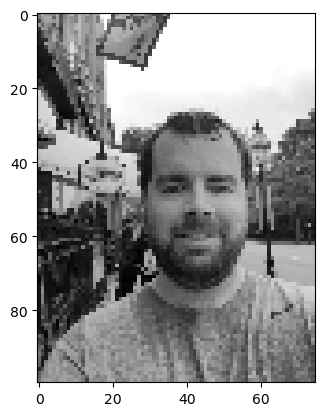

In [7]:
plt.imshow(train_lab_images[1][..., 0], cmap="gray")
plt.show()

In [8]:
def conv2d_block(x, channel):
    x = Conv2D(channel, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(channel, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

In [10]:
def unet_lab():
    inputs = Input((100, 75, 1))

    c1 = conv2d_block(inputs, 16)
    p1 = MaxPool2D(2)(c1)
    p1 = Dropout(0.1)(p1)

    c2 = conv2d_block(p1, 32)
    p2 = MaxPool2D(2)(c2)
    p2 = Dropout(0.1)(p2)

    c3 = conv2d_block(p2, 64)
    p3 = MaxPool2D(2)(c3)
    p3 = Dropout(0.1)(p3)

    c4 = conv2d_block(p3, 128)
    p4 = MaxPool2D(2)(c4)
    p4 = Dropout(0.1)(p4)

    c5 = conv2d_block(p4, 256)

    u6 = Conv2DTranspose(128, 2, 2, padding="valid", output_padding=(0, 1))(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(0.1)(u6)
    c6 = conv2d_block(u6, 128)

    u7 = Conv2DTranspose(64, 2, 2, padding="valid", output_padding=(1, 0))(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(0.1)(u7)
    c7 = conv2d_block(u7, 64)

    u8 = Conv2DTranspose(32, 2, 2, padding="valid", output_padding=(0, 1))(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(0.1)(u8)
    c8 = conv2d_block(u8, 32)

    u9 = Conv2DTranspose(16, 2, 2, padding="valid", output_padding=(0, 1))(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(0.1)(u9)
    c9 = conv2d_block(u9, 16)

    outputs = Conv2D(2, 1, activation="sigmoid")(c9)
    model = Model(inputs, outputs)
    return model

In [11]:
model2 = unet_lab()
model2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 75, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 100, 75, 16)  160         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 100, 75, 16)  64         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [12]:
model2.compile(loss="mse", optimizer="adam", metrics=["accuracy"])

In [16]:
checkpoint_callback = ModelCheckpoint(
    filepath="best_model.keras",
    monitor="val_accuracy",
    save_best_only=True,
    mode="max",
    verbose=1,
)

In [17]:
hist = model2.fit(
    train_lab_images[..., 0:1],
    train_lab_images[..., 1:],
    validation_data=(test_lab_images[..., 0:1], test_lab_images[..., 1:]),
    epochs=500,
    verbose=1,
    callbacks=[checkpoint_callback],
)

Epoch 1/500


2025-10-28 10:09:47.788084: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


54/54 [==============================] - ETA: 0s - loss: 0.0105 - accuracy: 0.5181
Epoch 1: val_accuracy improved from -inf to 0.59810, saving model to best_model.keras
54/54 [==============================] - 4s 50ms/step - loss: 0.0105 - accuracy: 0.5181 - val_loss: 0.0027 - val_accuracy: 0.5981
Epoch 2/500
53/54 [============================>.] - ETA: 0s - loss: 0.0032 - accuracy: 0.5753
Epoch 2: val_accuracy did not improve from 0.59810
54/54 [==============================] - 2s 33ms/step - loss: 0.0032 - accuracy: 0.5750 - val_loss: 0.0028 - val_accuracy: 0.5967
Epoch 3/500
53/54 [============================>.] - ETA: 0s - loss: 0.0032 - accuracy: 0.5735
Epoch 3: val_accuracy did not improve from 0.59810
54/54 [==============================] - 2s 34ms/step - loss: 0.0032 - accuracy: 0.5732 - val_loss: 0.0054 - val_accuracy: 0.5937
Epoch 4/500
53/54 [============================>.] - ETA: 0s - loss: 0.0029 - accuracy: 0.5925
Epoch 4: val_accuracy improved from 0.59810 to 0.62351

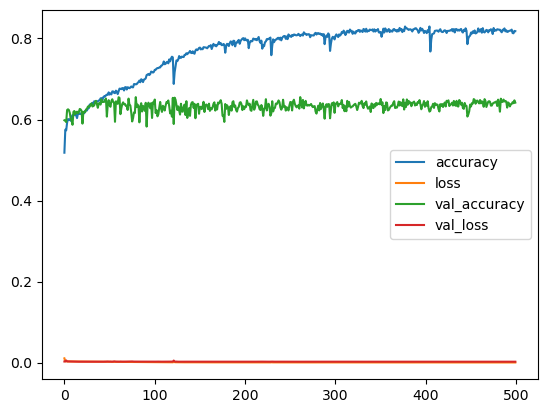

In [18]:
plt.plot(hist.history["accuracy"], label="accuracy")
plt.plot(hist.history["loss"], label="loss")
plt.plot(hist.history["val_accuracy"], label="val_accuracy")
plt.plot(hist.history["val_loss"], label="val_loss")
plt.legend(loc="right")
plt.show()

In [ ]:
res = model2.predict(test_lab_images[1:2][..., 0:1])


def l2rgb(l):
    pred_ab = model2.predict(np.expand_dims(l, (0, -1)))  # 차원을 추가
    pred_img = np.zeros((100, 75, 3))

    pred_img[:, :, 0] = l.reshape((100, 75))
    pred_img[:, :, 1:] = pred_ab[0]

    pred_lab = (pred_img * [100, 255, 255]) - [0, 128, 128]
    rgb_img = color.lab2rgb(pred_lab)
    return rgb_img

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step


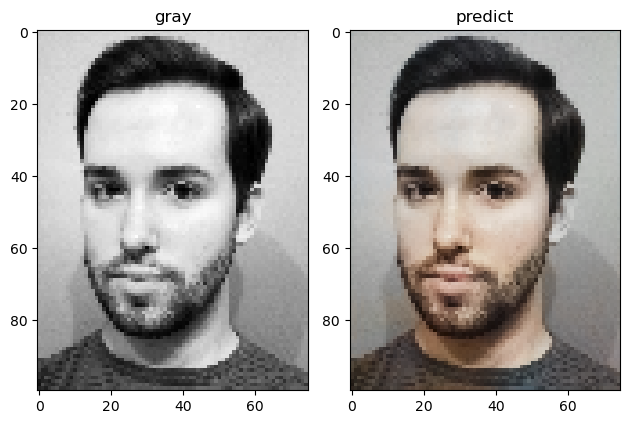

In [26]:
gray_image = test_lab_images[1][..., 0]
predict_image = l2rgb(test_lab_images[1][..., 0])
fig, axs = plt.subplots(nrows=1, ncols=2)
axs[0].imshow(gray_image, cmap="gray")
axs[0].set_title("gray")

axs[1].imshow(predict_image)
axs[1].set_title("predict")

plt.tight_layout()
plt.show()

In [21]:
model2.save("colorization_model_1028.keras")

In [22]:
model2.save_weights("colorization_model_1028_weights.h5")